In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 6
batch_size = 60
learning_rate = 0.0001
num_classes = 48
early_stop_accuracy = 0.95

dataset_path = r"C:\Users\user\Downloads\DL Dataset"  # Replace with the path to your dataset


In [9]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [10]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
class_names = full_dataset.classes  

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True) 

model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, num_classes) 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

early_stop = False

In [ ]:
for epoch in range(num_epochs):
    if early_stop:  # If early stopping is triggered, break the loop
        break
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Calculate epoch accuracy
    train_accuracy = correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    # Early stopping condition
    if train_accuracy >= early_stop_accuracy:
        print(f"Early stopping triggered at epoch {epoch + 1}, training accuracy reached {train_accuracy:.4f}.")
        early_stop = True

# Save the final trained model
torch.save(model.state_dict(), "model_odia_characters.pth")
print("Model training complete and saved.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


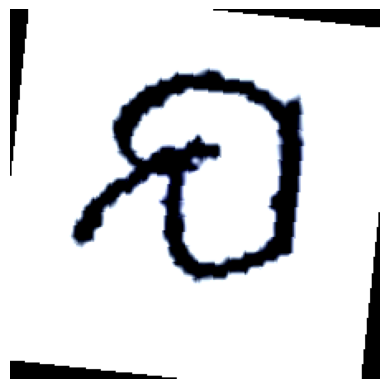

Folder Label (Actual): ଯ (jya), Predicted Label: ଯ (jya)


In [ ]:
def random_test_sample():
    # Pick a random image from the test set
    random_idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_idx]
    folder_label = class_names[label]  # Get actual label from folder name
    
    # Display the image
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize for visualization
    plt.axis('off')
    plt.show()

    # Predict the label
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get the predicted label
        predicted_label = class_names[predicted.item()]

    print(f"Folder Label (Actual): {folder_label}, Predicted Label: {predicted_label}")

# Testing the model with a new random image each time the function is called
random_test_sample()  # Call this function to display a random image and its prediction

Loss and accuracy graph

In [ ]:
# Initialize lists to track loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Validation loop (if you have a validation set, optional)
if 'val_loader' in locals():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct_predictions / total_samples
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_accuracy)
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



import matplotlib.pyplot as plt

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_accuracies:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch [1/6], Loss: 0.4447, Accuracy: 0.8606


KeyboardInterrupt: 

Confusion Matrix

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2821 (\N{ORIYA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Oriya natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2822 (\N{ORIYA LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2823 (\N{ORIYA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2824 (\N{ORIYA LETTER II}) missing from font(s) 

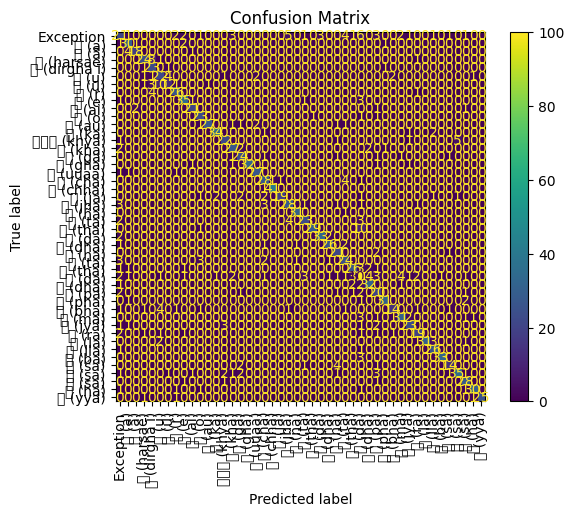

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate model on test set and collect predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.item())
        all_labels.append(labels.item())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


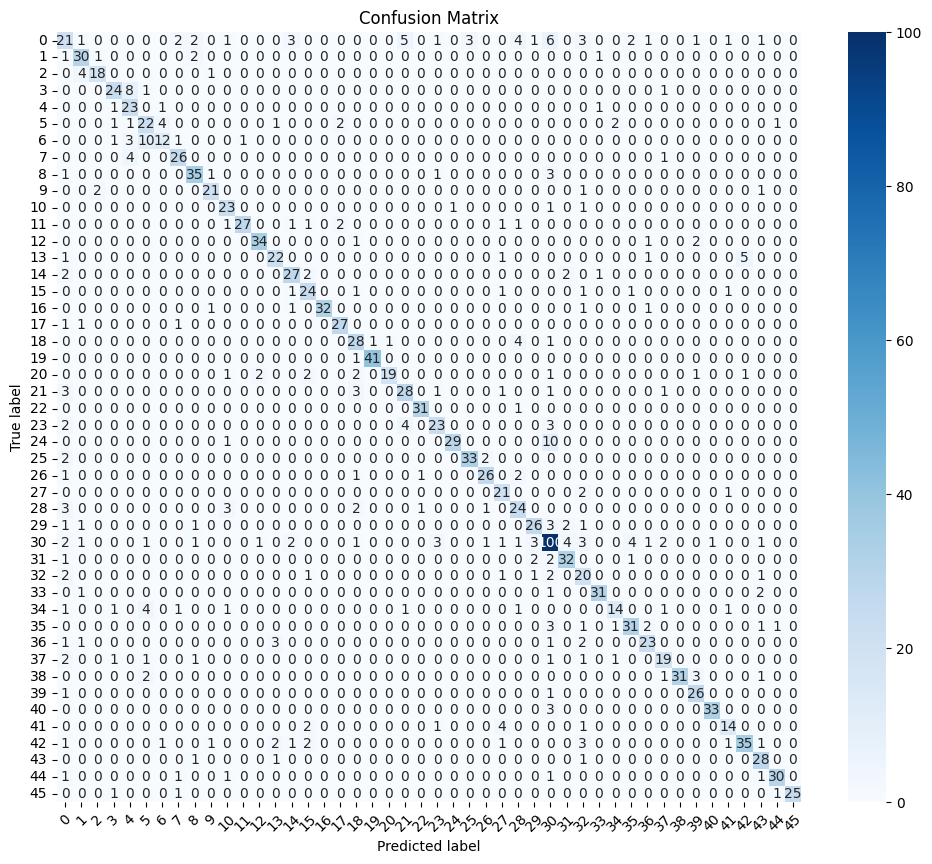

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a confusion matrix stored in a variable `cm`
plt.figure(figsize=(12, 10))  # Increase plot size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()

ROC AUC CURVE

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2821 (\N{ORIYA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Oriya natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2822 (\N{ORIYA LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2823 (\N{ORIYA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2824 (\N{ORIYA LETTER II}) missing from font(s) 

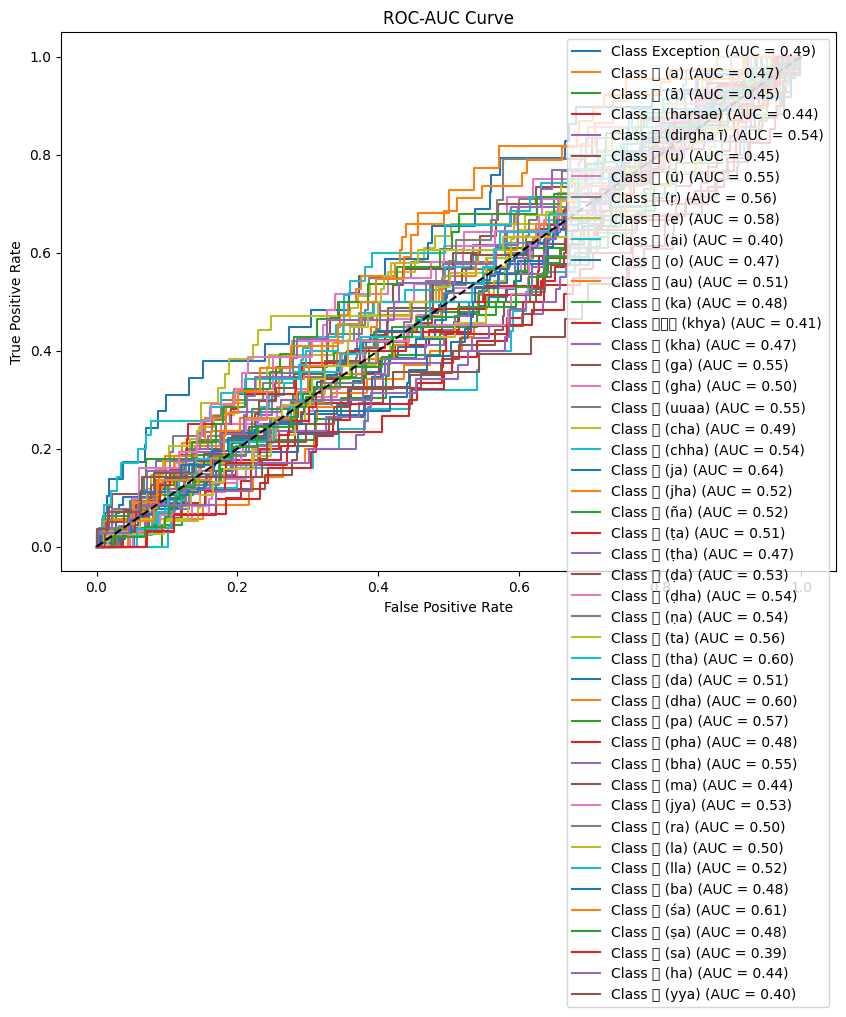

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Get probabilities for each class
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)

# Plot ROC for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_9060\1139539019.py:35: UserWarning: Glyph 2821 (\N{ORIYA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to make space for legend
C:\Users\user\AppData\Local\Temp\ipykernel_9060\1139539019.py:35: UserWarning: Matplotlib currently does not support Oriya natively.
  plt.tight_layout()  # Adjust layout to make space for legend
C:\Users\user\AppData\Local\Temp\ipykernel_9060\1139539019.py:35: UserWarning: Glyph 2822 (\N{ORIYA LETTER AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to make space for legend
C:\Users\user\AppData\Local\Temp\ipykernel_9060\1139539019.py:35: UserWarning: Glyph 2823 (\N{ORIYA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust layout to make space for legend
C:\Users\user\AppData\Local\Temp\ipykernel_9060\1139539019.py:35: UserWarning: Glyph 2824 (\N{ORIYA LETTER II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust la

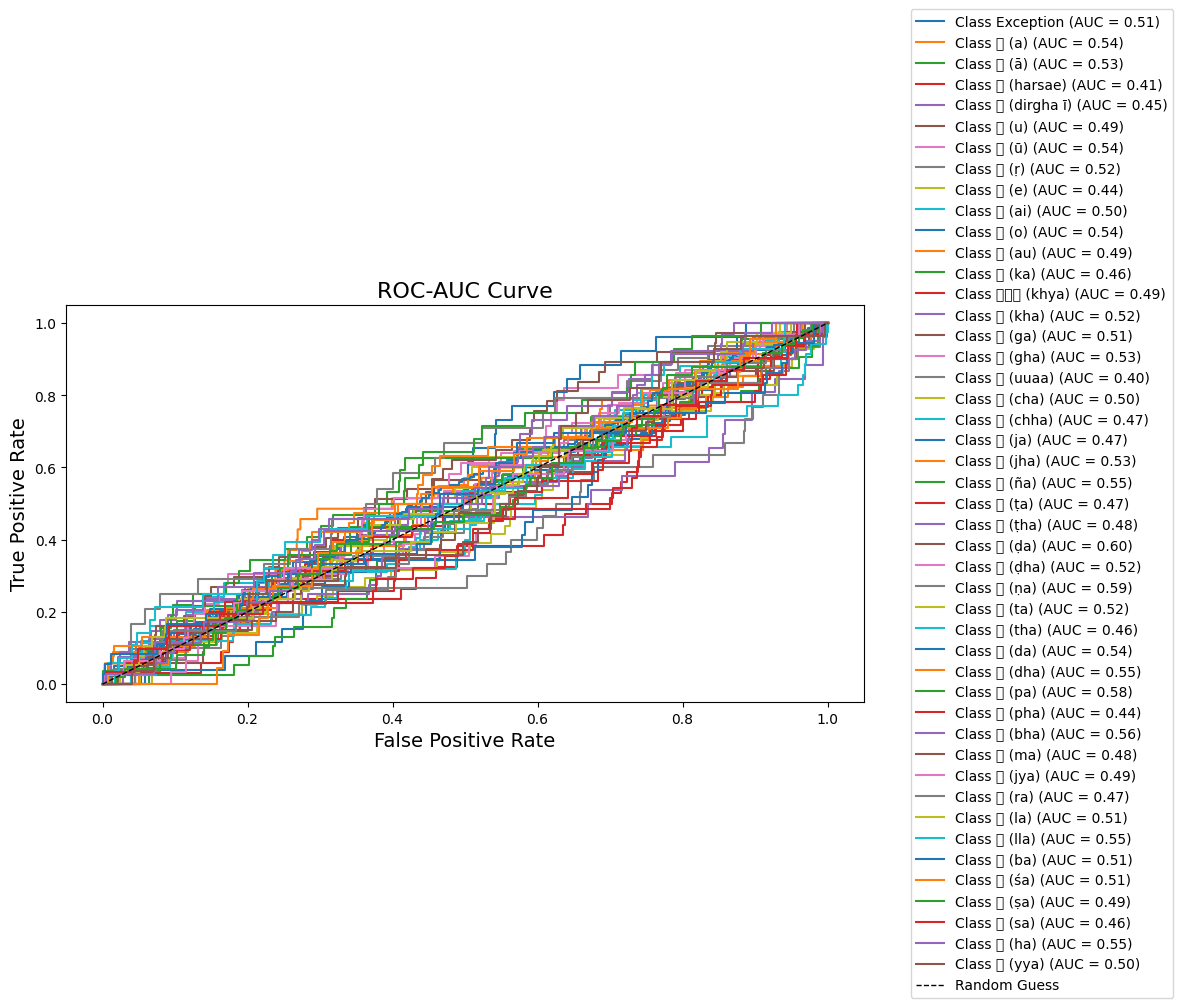

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# Get probabilities for each class
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.vstack(all_probs)

# Plot ROC for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1.0, label='Random Guess')  # Diagonal line for random guess
plt.title("ROC-AUC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

# Place the legend outside the plot to prevent overlapping
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10, frameon=True)

plt.tight_layout()  # Adjust layout to make space for legend
plt.show()


CLASSIFICATION REPORT
ACCURACY-LOSS-VALIDATION GRAPH
50 EPOCH AND USE EARLY STOPPING
TRAINING 70% TESTING 205 VALIDATION 10%- SHOW ACCURACY/LOSS FOR ALL 3 